In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import tensorflow as tf



## Early  preprocessing:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
df_all = pd.read_csv('/data/Data_Entry_2017.csv')
image_paths = {os.path.basename(x): x for x in 
               glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(image_paths), ', Total Headers', df_all.shape[0])
df_all['path'] = df_all['Image Index'].map(image_paths.get)
df_all.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
78707,00019308_009.png,Edema|Effusion|Infiltration,9,19308,61,F,AP,2500,2048,0.168,0.168,NaN,/data/images_009/images/00019308_009.png
100808,00026778_000.png,No Finding,0,26778,52,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00026778_000.png
20369,00005448_011.png,No Finding,11,5448,60,M,AP,2500,2048,0.168,0.168,NaN,/data/images_003/images/00005448_011.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

finding_names = list(set(l for findings in df_all["Finding Labels"] for l in findings.split('|')))
print("Finding labels that occur in the data set:\n\n\t"+'\n\t'.join(finding_names))


for finding_name in finding_names:
    df_all[finding_name] = df_all["Finding Labels"].apply(lambda x : int(finding_name in x.split('|')))

df_all.sample(3)

Finding labels that occur in the data set:

	Mass
	Edema
	Effusion
	Fibrosis
	Pneumothorax
	Consolidation
	Pleural_Thickening
	Pneumonia
	Atelectasis
	Emphysema
	Infiltration
	Nodule
	Hernia
	Cardiomegaly
	No Finding


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Consolidation,Pleural_Thickening,Pneumonia,Atelectasis,Emphysema,Infiltration,Nodule,Hernia,Cardiomegaly,No Finding
34827,00009190_000.png,No Finding,0,9190,61,F,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,1
43606,00011237_070.png,Atelectasis|Consolidation|Infiltration,70,11237,56,F,AP,2500,2048,0.168000,...,1,0,0,1,0,1,0,0,0,0
106364,00028644_007.png,No Finding,7,28644,39,M,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,0,0,1


In [4]:
# keras wants a column of class labels to consist of strings, so let's prepare that for it:
df_all['class_label'] = df_all['Pneumonia'].apply(lambda x : 'pneumonia' if x==1 else 'nomonia')
df_all.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pleural_Thickening,Pneumonia,Atelectasis,Emphysema,Infiltration,Nodule,Hernia,Cardiomegaly,No Finding,class_label
5255,00001397_002.png,Effusion,2,1397,54,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,nomonia
60877,00015031_013.png,No Finding,13,15031,39,F,PA,2398,2991,0.143,...,0,0,0,0,0,0,0,0,1,nomonia
60376,00014907_002.png,No Finding,2,14907,63,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,nomonia


## Create training and testing data:

In [5]:
# fraction of validation set that is negative cases. guessing what it might be in clinical setting.
frac_neg_valid = 0.9 

num_pos_all = sum(df_all['Pneumonia']==1)
num_pos_valid = int(0.2*num_pos_all)
num_neg_valid = int(frac_neg_valid/ (1-frac_neg_valid) * num_pos_valid)
num_pos_train = num_pos_all - num_pos_valid
num_neg_train = num_pos_train # training set will have 50-50 split of pos and neg cases

df_pos_all = df_all[df_all['Pneumonia']==1]
df_pos_all = df_pos_all.sample(frac=1.0) # shuffle
df_pos_valid = df_pos_all.iloc[:num_pos_valid]
df_pos_train = df_pos_all.iloc[num_pos_valid:]
assert(len(df_pos_train)==num_pos_train)

df_neg_all = df_all[df_all['Pneumonia']==0]
df_neg_all = df_neg_all.sample(frac=1.0) # shuffle
df_neg_valid = df_neg_all.iloc[:num_neg_valid]
df_neg_train_pool = df_neg_all.iloc[num_neg_valid:] # see make_df_train docstring below

# validation data is now fixed throughout training:
df_valid = pd.concat([df_pos_valid,df_neg_valid]).sample(frac=1.0)  

# training data has fixed set of positive cases, but let's allow switching out negative cases for fresh ones
def make_df_train(df_pos_train, df_neg_train_pool):
    """Return training data made using the fixed df_pos_train and a random selection
    of an equal number of entries from the fixed df_neg_train_pool. It will be a
    50-50 split between positive and negative cases, but the negative cases selected will vary each time 
    this function is called."""
    df_neg_train_pool = df_neg_train_pool.sample(frac=1.0) # shuffle
    df_neg_train = df_neg_train_pool[:num_neg_train]
    return pd.concat([df_pos_train,df_neg_train]).sample(frac=1.0)

# just sanity-checking the function make_df_train
assert(sum(make_df_train(df_pos_train, df_neg_train_pool)['Pneumonia']==1) == num_pos_train)
assert(sum(make_df_train(df_pos_train, df_neg_train_pool)['Pneumonia']==0) == num_neg_train)

print("The validation set consists of {} images, of which {} are positive cases.".format(
        num_pos_valid + num_neg_valid,
        num_pos_valid
    )
)
print("The training set will consist of {} images, of which {} are positive cases.".format(
        num_pos_train + num_neg_train,
        num_pos_train
    )
)

The validation set consists of 2860 images, of which 286 are positive cases.
The training set will consist of 2290 images, of which 1145 are positive cases.


# Now we can begin our model-building & training

image augmentation

In [6]:
idg_train = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=6,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode="constant",
    cval=0, # black background behind rotation/shift
    horizontal_flip=False, # see comment below
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)

idg_valid = tf.keras.preprocessing.image.ImageDataGenerator()


I do not think horizontal flip makes sense as an augmentation here. It's true that there are AP and PA orientations, but those are front-back flipped which is not the same to an X-ray as a left-right flip. Human anatomy is not left-right symmetric. Unless a patient has the rare conditon Situs Inversus, their heart will always be on the same side in the X-ray.

In [7]:
def make_dataframe_iterator_train():
    return idg_train.flow_from_dataframe(
        make_df_train(df_pos_train, df_neg_train_pool),
        directory=None,
        x_col="path",
        y_col="class_label",
        weight_col=None,
        target_size=(224, 224),
        color_mode="rgb",
        classes=None,
        class_mode="binary",
        batch_size=64, # TODO definitely mess with this
        shuffle=True, # I already shuffled it but sure
        seed=None,
        subset=None,
        interpolation="nearest",
        validate_filenames=True,
    )

dataframe_iterator_train = make_dataframe_iterator_train()

dataframe_iterator_valid = idg_valid.flow_from_dataframe(
    df_valid,
    directory=None,
    x_col="path",
    y_col="class_label",
    weight_col=None,
    target_size=(224, 224), # TODO make sure this is correct for pretrained model you pick like VGG16
    color_mode="rgb",
    classes=None,
    class_mode="binary",
    batch_size=64, # TODO definitely mess with this
    shuffle=True, # I already shuffled it but sure
    seed=None,
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 2290 validated image filenames belonging to 2 classes.
Found 2860 validated image filenames belonging to 2 classes.


In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = dataframe_iterator_valid.next()

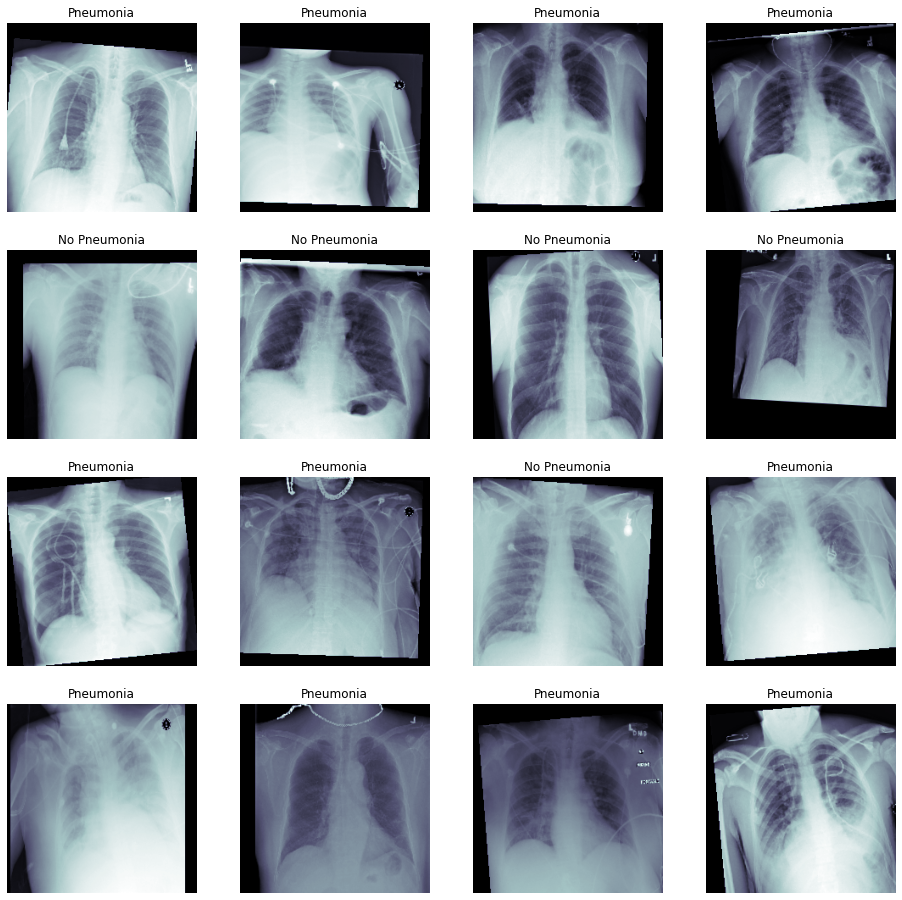

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(dataframe_iterator_train)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build model: 

In [25]:
vgg_model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
)

In [26]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [27]:
for layer in vgg_model.layers[:19]: # 15 to freeze all but last conv layers, 19 to freez all conv layers
    layer.trainable = False

vgg_model_truncated = tf.keras.Model(vgg_model.input,vgg_model.layers[19].output)

vgg_model_truncated.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [28]:
inputs = tf.keras.Input(shape=(224,224,3), dtype='float32')
x = vgg_model_truncated(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x) # final output is logit, needs sigmoid to be applied still
# TODO consider actually training on all classes
outputs = x
model = tf.keras.Model(inputs, outputs)

In [29]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [30]:
@tf.function
def train_on_batch(t_x,t_y):
    with tf.GradientTape() as tape:
        logits = model(t_x, training=True)
        logits = tf.reshape(logits, (-1,))
        loss = loss_fn(t_y, logits)
        gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return loss

@tf.function
def validation_loss(v_x,v_y):
    logits = model(v_x, training=False)
    logits = tf.reshape(logits, (-1,))
    loss = loss_fn(v_y, logits)
    return loss

@tf.function
def inference_on_batch(x):
    logits = model(x, training=False)
    logits = tf.reshape(logits, (-1,))
    return tf.sigmoid(logits)

### Training

In [32]:
batches_per_epoch = len(dataframe_iterator_train)
num_epochs = 20

losses=[]
for epoch in range(num_epochs):
    
    batch_count = 0
    dataframe_iterator_train = make_dataframe_iterator_train() # choose different negative images
    
    for t_x, t_y in dataframe_iterator_train:
        
        t_loss = train_on_batch(t_x,t_y).numpy()
        v_loss = validation_loss(valX, valY).numpy()
        losses.append([t_loss, v_loss])
    
        print("Batch {} of epoch {}; training loss: {}, val loss: {}".format(batch_count, epoch, t_loss, v_loss))
        
        batch_count += 1
        if batch_count >= batches_per_epoch:
            break
#         if batch_count >5: break # TODO remove this!

losses = np.array(losses)

Found 2290 validated image filenames belonging to 2 classes.
Batch 0 of epoch 0; training loss: 6.40516471862793, val loss: 1.3457525968551636
Batch 1 of epoch 0; training loss: 6.466734886169434, val loss: 1.598207950592041
Batch 2 of epoch 0; training loss: 6.57144832611084, val loss: 1.994241714477539
Batch 3 of epoch 0; training loss: 8.078490257263184, val loss: 2.104430675506592
Batch 4 of epoch 0; training loss: 7.391664505004883, val loss: 1.8310514688491821
Batch 5 of epoch 0; training loss: 5.1192708015441895, val loss: 1.88138747215271
Batch 6 of epoch 0; training loss: 8.55041217803955, val loss: 2.3589296340942383
Batch 7 of epoch 0; training loss: 4.684284210205078, val loss: 2.163027286529541
Batch 8 of epoch 0; training loss: 4.851738929748535, val loss: 2.123424530029297
Batch 9 of epoch 0; training loss: 7.686966896057129, val loss: 2.0637664794921875
Batch 10 of epoch 0; training loss: 4.72107458114624, val loss: 2.0221962928771973
Batch 11 of epoch 0; training loss:

Batch 24 of epoch 2; training loss: 2.423780679702759, val loss: 0.8029437065124512
Batch 25 of epoch 2; training loss: 3.158390522003174, val loss: 0.7198362350463867
Batch 26 of epoch 2; training loss: 3.6587162017822266, val loss: 0.6626037359237671
Batch 27 of epoch 2; training loss: 4.687018394470215, val loss: 0.6217728853225708
Batch 28 of epoch 2; training loss: 4.750182628631592, val loss: 0.6183576583862305
Batch 29 of epoch 2; training loss: 3.7800025939941406, val loss: 0.6403295993804932
Batch 30 of epoch 2; training loss: 3.4215517044067383, val loss: 0.6463773250579834
Batch 31 of epoch 2; training loss: 2.7875661849975586, val loss: 0.6681919097900391
Batch 32 of epoch 2; training loss: 3.719634771347046, val loss: 0.7202175259590149
Batch 33 of epoch 2; training loss: 3.7387020587921143, val loss: 0.8228951692581177
Batch 34 of epoch 2; training loss: 3.2809481620788574, val loss: 0.9261607527732849
Batch 35 of epoch 2; training loss: 3.703518867492676, val loss: 1.081

Batch 12 of epoch 5; training loss: 2.210125207901001, val loss: 1.213077425956726
Batch 13 of epoch 5; training loss: 2.0328850746154785, val loss: 1.2044951915740967
Batch 14 of epoch 5; training loss: 1.6825624704360962, val loss: 1.2116103172302246
Batch 15 of epoch 5; training loss: 2.160292148590088, val loss: 1.2751452922821045
Batch 16 of epoch 5; training loss: 1.6961071491241455, val loss: 1.3341044187545776
Batch 17 of epoch 5; training loss: 2.777806282043457, val loss: 1.380497694015503
Batch 18 of epoch 5; training loss: 2.5663957595825195, val loss: 1.369533658027649
Batch 19 of epoch 5; training loss: 2.3503034114837646, val loss: 1.3059133291244507
Batch 20 of epoch 5; training loss: 1.935225248336792, val loss: 1.2171695232391357
Batch 21 of epoch 5; training loss: 2.2314562797546387, val loss: 1.1212141513824463
Batch 22 of epoch 5; training loss: 2.4105467796325684, val loss: 1.0307402610778809
Batch 23 of epoch 5; training loss: 1.9935669898986816, val loss: 0.9323

Batch 0 of epoch 8; training loss: 1.0669387578964233, val loss: 0.6203948259353638
Batch 1 of epoch 8; training loss: 1.489290475845337, val loss: 0.6185628175735474
Batch 2 of epoch 8; training loss: 1.74819016456604, val loss: 0.6174850463867188
Batch 3 of epoch 8; training loss: 1.2228513956069946, val loss: 0.6137590408325195
Batch 4 of epoch 8; training loss: 1.494171380996704, val loss: 0.6171283721923828
Batch 5 of epoch 8; training loss: 1.044219970703125, val loss: 0.6172488331794739
Batch 6 of epoch 8; training loss: 1.6715035438537598, val loss: 0.6184126734733582
Batch 7 of epoch 8; training loss: 1.4240541458129883, val loss: 0.6125490069389343
Batch 8 of epoch 8; training loss: 1.6624864339828491, val loss: 0.6047249436378479
Batch 9 of epoch 8; training loss: 1.987489938735962, val loss: 0.6009585857391357
Batch 10 of epoch 8; training loss: 1.4827672243118286, val loss: 0.5972011089324951
Batch 11 of epoch 8; training loss: 1.35404372215271, val loss: 0.594468653202056

Batch 24 of epoch 10; training loss: 0.9700716137886047, val loss: 0.6167016625404358
Batch 25 of epoch 10; training loss: 1.0623396635055542, val loss: 0.6067492365837097
Batch 26 of epoch 10; training loss: 1.3893253803253174, val loss: 0.598839282989502
Batch 27 of epoch 10; training loss: 1.32485032081604, val loss: 0.5951429605484009
Batch 28 of epoch 10; training loss: 1.0253721475601196, val loss: 0.5897669792175293
Batch 29 of epoch 10; training loss: 1.4469571113586426, val loss: 0.5842978954315186
Batch 30 of epoch 10; training loss: 1.0229207277297974, val loss: 0.5793735384941101
Batch 31 of epoch 10; training loss: 0.8210744857788086, val loss: 0.573594331741333
Batch 32 of epoch 10; training loss: 1.3243110179901123, val loss: 0.5693585872650146
Batch 33 of epoch 10; training loss: 0.7694265246391296, val loss: 0.5636523962020874
Batch 34 of epoch 10; training loss: 0.9541870951652527, val loss: 0.5612545013427734
Batch 35 of epoch 10; training loss: 1.1809163093566895, v

Batch 10 of epoch 13; training loss: 0.9236703515052795, val loss: 0.679438591003418
Batch 11 of epoch 13; training loss: 0.9284666776657104, val loss: 0.6801073551177979
Batch 12 of epoch 13; training loss: 1.135448932647705, val loss: 0.6803255081176758
Batch 13 of epoch 13; training loss: 1.0808837413787842, val loss: 0.6780461072921753
Batch 14 of epoch 13; training loss: 0.8242068290710449, val loss: 0.6757907271385193
Batch 15 of epoch 13; training loss: 0.9318637847900391, val loss: 0.6733518838882446
Batch 16 of epoch 13; training loss: 1.0016521215438843, val loss: 0.671315610408783
Batch 17 of epoch 13; training loss: 0.890092134475708, val loss: 0.6688332557678223
Batch 18 of epoch 13; training loss: 0.902759313583374, val loss: 0.666806697845459
Batch 19 of epoch 13; training loss: 0.9233255386352539, val loss: 0.6656675934791565
Batch 20 of epoch 13; training loss: 0.9432588815689087, val loss: 0.6661525964736938
Batch 21 of epoch 13; training loss: 1.0271254777908325, val

Batch 33 of epoch 15; training loss: 0.7284984588623047, val loss: 0.6984199285507202
Batch 34 of epoch 15; training loss: 0.8910986185073853, val loss: 0.6992968320846558
Batch 35 of epoch 15; training loss: 0.6779070496559143, val loss: 0.6999046802520752
Found 2290 validated image filenames belonging to 2 classes.
Batch 0 of epoch 16; training loss: 0.6773694753646851, val loss: 0.6994438171386719
Batch 1 of epoch 16; training loss: 0.9777083992958069, val loss: 0.6992831230163574
Batch 2 of epoch 16; training loss: 0.9700003862380981, val loss: 0.698197603225708
Batch 3 of epoch 16; training loss: 0.7272719144821167, val loss: 0.6964638829231262
Batch 4 of epoch 16; training loss: 0.9597921371459961, val loss: 0.6951314210891724
Batch 5 of epoch 16; training loss: 0.7001326084136963, val loss: 0.6937744617462158
Batch 6 of epoch 16; training loss: 0.872264564037323, val loss: 0.6921987533569336
Batch 7 of epoch 16; training loss: 0.7093933820724487, val loss: 0.6912404298782349
Bat

KeyboardInterrupt: 

Todo next:

- (done) figure out a nice way to gather probabilities and labels in validation data as trying to do below
- (done) set up a cell, perhaps the below one, to take a threshold and print metrics like sensitivity and precision
- save best model during training using a patience value, and save model to json at end
- (done) work out the metrics they ask for below
- go back and play with learning rate and batch size
- go back and include all classes rather than just pneumonia, cutting down to pneum only for inference
- include AP and PA info into model

In [33]:
num_validation_batches = len(dataframe_iterator_valid)
probabilities = np.array([], dtype='float32')
ground_truth = np.array([], dtype='float32')
batch_count = 0
for v_x, v_y in dataframe_iterator_valid:
    probabilities = np.concatenate((probabilities, inference_on_batch(v_x)))
    ground_truth = np.concatenate((ground_truth, v_y))
    batch_count += 1
    if batch_count%10==0:
        print("worked through batch {}  of {}".format(batch_count, num_validation_batches))
    if batch_count >= num_validation_batches:
        break


worked through batch 10  of 45
worked through batch 20  of 45
worked through batch 30  of 45
worked through batch 40  of 45


In [39]:
def stats_for_threshold(threshold):
    probabilities >= threshold
    num_TP = ((probabilities >= threshold) & (ground_truth == 1.0)).sum()
    num_FP = ((probabilities >= threshold) & (ground_truth == 0.0)).sum()
    num_TN = ((probabilities < threshold) & (ground_truth == 0.0)).sum()
    num_FN = ((probabilities < threshold) & (ground_truth == 1.0)).sum()
    sensitivity = num_TP / (num_TP + num_FN)
    specificity = num_TN / (num_TN + num_FP)
    precision = num_TP / (num_TP + num_FP)
    false_pos_rate = num_FP/ (num_FP + num_TN)
    return sensitivity, specificity, precision, false_pos_rate

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

training history, ROC curve, and precision recall curve:

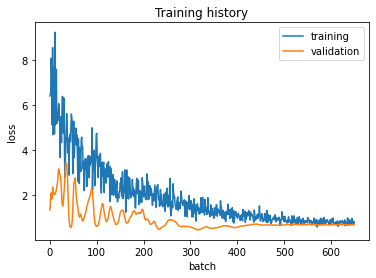

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


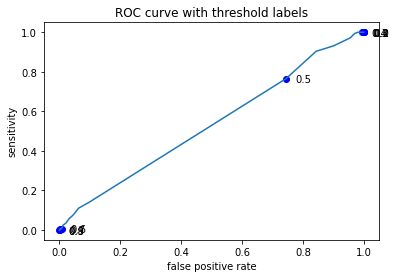

posx and posy should be finite values
posx and posy should be finite values


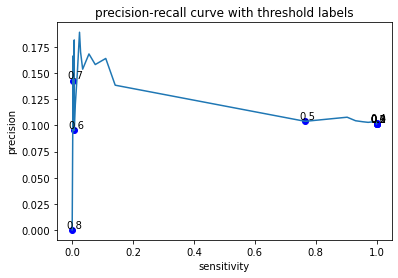

In [40]:
plt.plot(losses[:,0], label='training')
plt.plot(losses[:,1], label='validation')
plt.title('Training history')
plt.legend()
plt.xlabel('batch')
plt.ylabel('loss')
plt.show()


thresholds = np.arange(0.0, 1.0, 0.01)
stats = np.array([stats_for_threshold(threshold) for threshold in thresholds])
sensitivities = stats[:,0]
specificities = stats[:,1]
precisions = stats[:,2]
fprs = stats[:,3]

plt.plot(fprs, sensitivities)
plt.xlabel('false positive rate')
plt.ylabel('sensitivity')
plt.title('ROC curve with threshold labels')
for i in range(0,len(stats),10):
    x = fprs[i]
    y = sensitivities[i]
    plt.scatter(x,y,color='blue')
    plt.text(x+0.03,y-0.02,str(round(thresholds[i],3)))
plt.show()

plt.plot(sensitivities, precisions)
plt.xlabel('sensitivity')
plt.ylabel('precision')
plt.title('precision-recall curve with threshold labels')
for i in range(0,len(stats),10):
    x = sensitivities[i]
    y = precisions[i]
    plt.scatter(x,y,color='blue')
    plt.text(x-0.02,y+0.002,str(round(thresholds[i],3)))
plt.show()

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [38]:
def optimal_threshold_for_fbeta(beta):
    fscores = np.array([[thres,(1+beta**2)*(prec*sens)/((beta**2)*prec+sens)] for thres, prec, sens in zip(thresholds, precisions, sensitivities)])
    return fscores[fscores[:,1].argmax(),0]

# Let's say we consider sensitivity to be twice as important as precision
threshold = optimal_threshold_for_fbeta(2)
threshold

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.74

In [22]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [23]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

NameError: name 'my_model' is not defined